In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.optimize import minimize

# 逻辑回归多分类

## 获取数据集

In [2]:
data = sio.loadmat("exp3data1.mat")
type(data)

dict

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [4]:
X = data["X"]
X = np.insert(X, 0, 1, axis=1)
Y = data["y"]
Y = Y.flatten()
X.shape, Y.shape

((5000, 401), (5000,))

---
特征：5000张20*20图片

标签：5000 * 1

---

In [5]:
np.unique(Y)  # 查看有几类标签

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [6]:
def plotImage(X):
    idx = np.random.randint(5000)
    img = X[idx,1:]
    fig, ax = plt.subplots(figsize=(1.5, 1.5))
    ax.matshow(img.reshape((20, 20)).T, cmap="gray_r")
    plt.xticks([])
    plt.yticks([])
    plt.show()

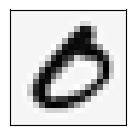

In [7]:
plotImage(X)

In [8]:
def plotImages(X):
    idxs = np.random.choice(np.arange(X.shape[0]), 100)
    imgs = X[idxs,1:]  # 随机选择100个图片绘制
    fig, ax = plt.subplots(nrows=10, ncols=10, sharey=True, sharex=True, figsize=(8, 8))
    for r in range(10):
        for c in range(10):
            ax[r, c].matshow(imgs[r * 10 + c].reshape(20, 20).T, cmap="gray_r")

    plt.xticks([])
    plt.yticks([])
    plt.show()

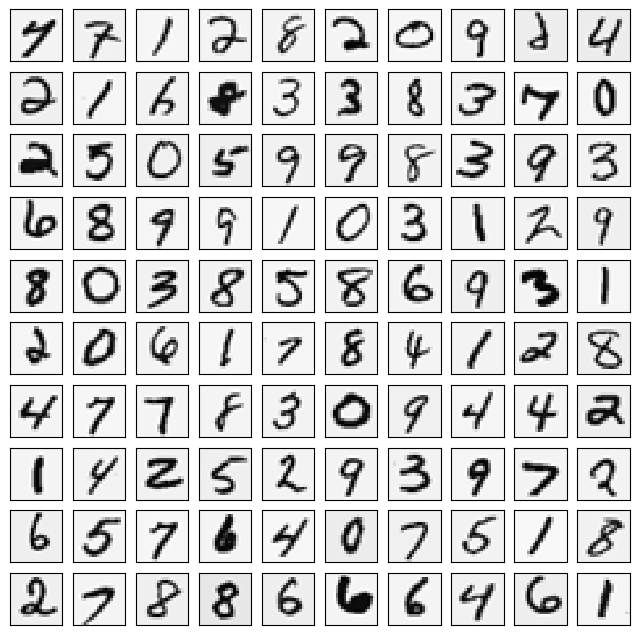

In [9]:
plotImages(X)

## 一对多回归模型

10个类，需要训练10个独立的分类器

$$
J(\theta) = \dfrac{1}{m} \sum_{i=1}^{m}{[-y^{(i)}\log(h_{\theta}(x^{(i)})) - (1 - y^{(i)})\log(1 - h_{\theta}(x^{(i)}))] + \dfrac{\lambda}{2m}}\sum_{j=1}^{n}\theta_j^2
$$

In [10]:
def sigmod(z):
    return 1 / (1 + np.exp(-z))

def costFunc(theta, X, Y, lr):
    theta_reg = theta[1:]
    first =  sigmod (-Y * np.log(sigmod(X@theta))) - (1 - Y) * np.log(1 - sigmod(X@theta))
    reg = (theta_reg@theta_reg) * lr / (2 * len(X))

    return np.mean(first) + reg

## 梯度函数

$$
\begin{aligned}
\theta_0 &:= \theta_0 - \alpha \dfrac{1}{m} \sum_{i=1}^{m}{[(h_{\theta}(x^{(i)})) - y^{(i)}]x_0^{(i)}}\\
\theta_j &:= \theta_j - \alpha \dfrac{1}{m} \sum_{i=1}^{m}{[(h_{\theta}(x^{(i)})) - y^{(i)}]x_j^{(i)} + \dfrac{\lambda}{m}}\theta_j
\end{aligned}
$$

In [11]:
def regularGradient(theta, X, Y, lr):
    theta_reg = theta[1:]
    first = (1 / len(X)) * X.T @ (sigmod(X @ theta) - Y)
    reg = np.concatenate([np.array([0]), (lr / len(X)) * theta_reg])  # 对\theta_0不惩罚

    return first + reg

## 训练多个正则化逻辑回归分类器

In [12]:
def oneVSall(X, Y, lr, K):
    """
    thetas: 10 * 401
    """
    thetas = np.zeros((K, X.shape[1]))  # X.shape[1] = 400 = 20 * 20
    for i in range(1, K+1):
        theta = np.zeros(X.shape[1])
        y_i = np.array([1 if label == i else 0 for label in Y])
        ret = minimize(fun=costFunc, x0=theta, args=(X, y_i, lr), method="TNC", jac=regularGradient, options={"disp": False})
        thetas[i-1, :] = ret.x

    return thetas

In [13]:
def predictAll(X, thetas):
    h = sigmod(X @ thetas.T)
    h_argmax = np.argmax(h, axis=1)
    h_argmax = h_argmax+1

    return h_argmax

In [14]:
thetas = oneVSall(X, Y, 1, 10)

In [15]:
y_predict = predictAll(X, thetas)
acc = np.mean(Y == y_predict)
print("accuracy = {}%".format(acc * 100))

accuracy = 85.6%
